In [1]:
!pip install torch_geometric umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import umap
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader 
from torch_geometric.nn import GATv2Conv, GraphNorm, global_mean_pool, global_max_pool
from torch_geometric import warnings as pyg_warnings

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pyg_warnings.filterwarnings("ignore", message=".*scatter.*")

Using device: cuda


Below I am loading, resizing, and normalizing the image data similarly to the VAE notebook, but while keeping it as NumPy arrays. 

In [ ]:
N_SAMPLES = 15000
VAL_SPLIT = 0.2
RESIZE_DIM = 64 

try:
    data_path = "/kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5"
    with h5py.File(data_path, 'r') as f:
        print(f"Keys in dataset: {list(f.keys())}")
        X_jets_raw = f['X_jets'][:N_SAMPLES] # (N, 125, 125, 3)
        y_raw = f['y'][:N_SAMPLES]           # (N,)
except FileNotFoundError:
    print("Kaggle path not found, trying local path './quark-gluon_data-set_n139306.hdf5'")
    data_path = "./quark-gluon_data-set_n139306.hdf5"
    try:
        with h5py.File(data_path, 'r') as f:
            print(f"Keys in dataset: {list(f.keys())}")
            X_jets_raw = f['X_jets'][:N_SAMPLES] # (N, 125, 125, 3)
            y_raw = f['y'][:N_SAMPLES]           # (N,)
    except FileNotFoundError:
        print(f"ERROR: Dataset not found at {data_path}. Please check the path.")
        X_jets_raw, y_raw = None, None 

if X_jets_raw is not None:
    print(f"Loaded X_jets shape: {X_jets_raw.shape}")
    print(f"Loaded y shape: {y_raw.shape}")
    X_jets = torch.tensor(X_jets_raw, dtype=torch.float32).permute(0, 3, 1, 2) 

    if RESIZE_DIM != 125:
        print(f"Resizing images to {RESIZE_DIM}x{RESIZE_DIM}...")
        X_jets = F.interpolate(X_jets, size=(RESIZE_DIM, RESIZE_DIM), mode='bilinear', align_corners=False) 

    print("Normalizing images per channel...")
    for i in tqdm(range(X_jets.shape[0]), desc="Normalizing"):
        for c in range(X_jets.shape[1]):
            channel = X_jets[i, c]
            min_val, max_val = channel.min(), channel.max()
            if max_val > min_val:
                 X_jets[i, c] = (channel - min_val) / (max_val - min_val)
            else:
                 X_jets[i, c] = torch.zeros_like(channel)
    X_jets = X_jets.numpy()
    y = y_raw.astype(np.int64)

    n_total = len(X_jets)
    n_val = int(VAL_SPLIT * n_total)
    n_train = n_total - n_val

    indices = np.arange(n_total)
    np.random.shuffle(indices)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    X_train, X_val = X_jets[train_indices], X_jets[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    print(f"\nTotal samples: {n_total}")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Image shape (CHW): {X_train.shape[1:]}")
else:
    print("Skipping further processing due to missing data.")

Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Loaded X_jets shape: (15000, 125, 125, 3)
Loaded y shape: (15000,)
Resizing images to 64x64...
Normalizing images per channel...


Normalizing:   0%|          | 0/15000 [00:00<?, ?it/s]


Total samples: 15000
Training set: 12000 samples
Validation set: 3000 samples
Image shape (CHW): (3, 64, 64)


This cell converts a 3-channel image into a point cloud by selecting only pixels whose combined intensity across channels exceeds a threshold and extracting the y,x coords of those selected pixels. The channel features are then extracted from them. An additional two new features are added as well(radial distance and polar angle). So the resultant points has 5 features

A graph is then created by using a knn to find the k nearest neighbours for each node based on their coords positions. Then the edges are added between each node and its k neighbours. The normalized euclidean distance between connected nodes is calculated and stored as an edge feature as well

In [4]:
K_NEIGHBORS = 8
POINT_THRESHOLD = 0.01

def image_to_pointcloud(image_3d, threshold=0.01):
    image_hwc = image_3d.transpose(1, 2, 0)
    h, w, c = image_hwc.shape

    grid_y, grid_x = np.indices((h, w)) 
    mask = np.sum(image_hwc, axis=-1) > threshold
    coords_yx = np.stack([grid_y[mask], grid_x[mask]], axis=-1)
    feats_3chan = image_hwc[mask]

    if coords_yx.shape[0] == 0: 
        return np.empty((0, 2)), np.empty((0, 5))

    center = np.array([h / 2.0, w / 2.0])
    offsets = coords_yx - center
    r = np.linalg.norm(offsets, axis=1, keepdims=True) / h 
    theta = np.arctan2(offsets[:, 1], offsets[:, 0] + 1e-8)
    theta = (theta / (2 * np.pi)) + 0.5 
    theta = theta.reshape(-1, 1)
    enhanced_feats = np.concatenate([feats_3chan, r, theta], axis=1) 

    return coords_yx, enhanced_feats


class JetGraphDataset(Dataset):

    def __init__(self, X_array, y_array, k=8, threshold=0.01, name="train"):
        self.X_array = X_array 
        self.y_array = y_array
        self.k = k
        self.threshold = threshold
        self.name = name 
        self.valid_indices = []
        print(f"\nProcessing {self.name} dataset to create graphs...")
        for idx in tqdm(range(len(X_array)), desc=f"Filtering {name} samples"):

            coords_yx, _ = image_to_pointcloud(X_array[idx], threshold)

            if coords_yx.shape[0] > 1: # min(self.k + 1, 2):
                self.valid_indices.append(idx)

        print(f"Filtered {self.name} set: {len(self.valid_indices)} / {len(X_array)} samples have > 1 point.")
        if len(self.valid_indices) == 0:
             warnings.warn("Warning: No valid samples found after filtering!")


    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):

        actual_idx = self.valid_indices[idx]
        image = self.X_array[actual_idx]
        label = self.y_array[actual_idx]

        coords_yx, node_features = image_to_pointcloud(image, self.threshold)
        num_nodes = node_features.shape[0]

        data = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            y=torch.tensor([label], dtype=torch.long),
            pos=torch.tensor(coords_yx, dtype=torch.float) 
        )


        if num_nodes > 1:

            current_k = min(self.k, num_nodes - 1)

            if current_k > 0:
                 nbrs = NearestNeighbors(n_neighbors=current_k + 1, algorithm='ball_tree').fit(coords_yx)
                 distances, indices = nbrs.kneighbors(coords_yx)

                 edge_list = []
                 edge_attrs = []
                 img_size = image.shape[1]

                 for i in range(num_nodes):
                     for j_idx in range(1, current_k + 1):
                         neighbor_node_idx = indices[i, j_idx]
                         edge_list.append([i, neighbor_node_idx])

                         dist = distances[i, j_idx]
                         normalized_dist = dist / img_size
                         edge_attr = [normalized_dist]

                         edge_attrs.append(edge_attr)

                 data.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                 data.edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

        if not hasattr(data, 'edge_index'):
             data.edge_index = torch.empty((2, 0), dtype=torch.long)
             data.edge_attr = torch.empty((0, 1), dtype=torch.float)

        return data


def visualize_point_cloud_3d(coords, features, title="Jet Point Cloud"):
    if coords.shape[0] == 0:
        print(f"Skipping visualization for '{title}': No points found.")
        return

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    x = coords[:, 1]
    y = coords[:, 0]
    z = features[:, 0] + features[:, 1] + features[:, 2]
    colors = features[:, 1]

    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', marker='o', s=15) 

    ax.set_xlabel("X coordinate (pixel)")
    ax.set_ylabel("Y coordinate (pixel)")
    ax.set_zlabel("Total Intensity")
    ax.set_title(title)
    fig.colorbar(scatter, label='ECAL Intensity (Channel 1)')
    plt.show()




Processing train dataset to create graphs...


Filtering train samples:   0%|          | 0/12000 [00:00<?, ?it/s]

Filtered train set: 12000 / 12000 samples have > 1 point.

Processing val dataset to create graphs...


Filtering val samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Filtered val set: 3000 / 3000 samples have > 1 point.

Visualizing example point clouds...


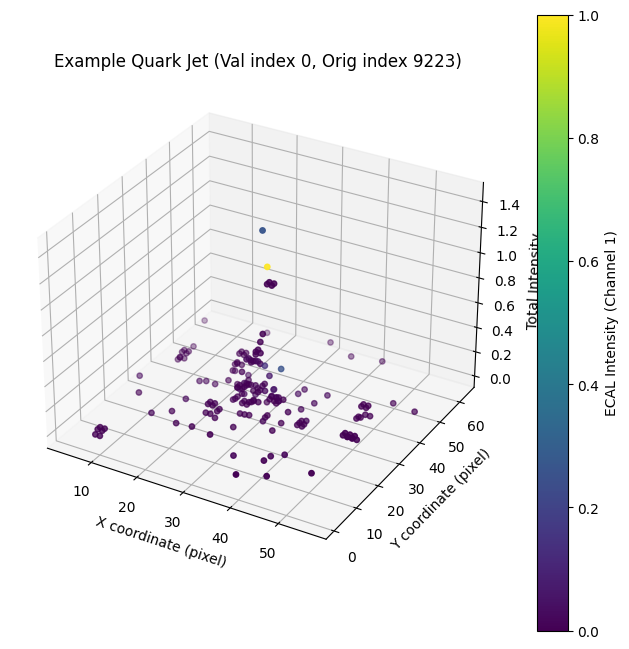

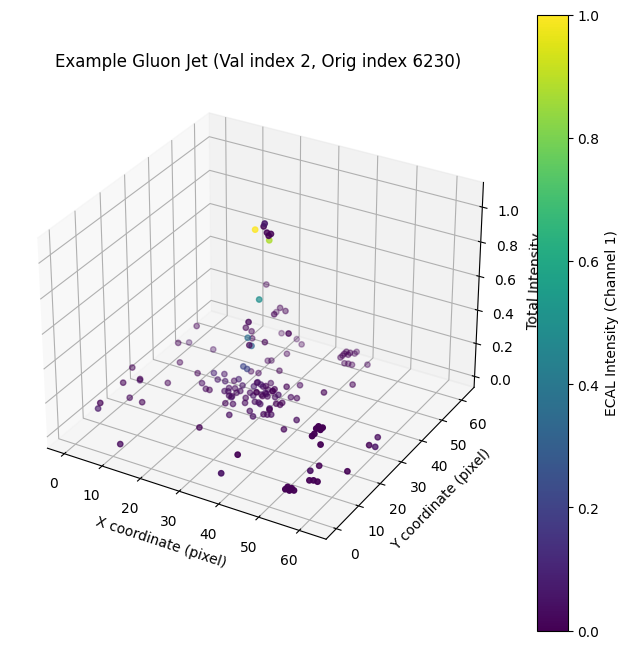

In [5]:
if 'X_train' in locals():
    train_dataset_pyg = JetGraphDataset(X_train, y_train, k=K_NEIGHBORS, threshold=POINT_THRESHOLD, name="train")
    val_dataset_pyg = JetGraphDataset(X_val, y_val, k=K_NEIGHBORS, threshold=POINT_THRESHOLD, name="val")
    print("\nVisualizing example point clouds...")
    val_indices_original = np.where(np.isin(np.arange(len(y_raw)), val_indices))[0]
    quark_example_idx_orig = -1
    gluon_example_idx_orig = -1


    

    for i, orig_idx in enumerate(val_indices):
        if y_raw[orig_idx] == 0 and quark_example_idx_orig == -1:
             quark_example_idx_orig = orig_idx
             quark_example_idx_val = i
        if y_raw[orig_idx] == 1 and gluon_example_idx_orig == -1:
             gluon_example_idx_orig = orig_idx
             gluon_example_idx_val = i 
        if quark_example_idx_orig != -1 and gluon_example_idx_orig != -1:
             break


    
    if quark_example_idx_orig != -1:
         coords_q, feats_q = image_to_pointcloud(X_val[quark_example_idx_val], threshold=POINT_THRESHOLD)
         visualize_point_cloud_3d(coords_q, feats_q, title=f"Example Quark Jet (Val index {quark_example_idx_val}, Orig index {quark_example_idx_orig})")
    else:
         print("Could not find a quark jet example in validation set for visualization.")

    if gluon_example_idx_orig != -1:
         coords_g, feats_g = image_to_pointcloud(X_val[gluon_example_idx_val], threshold=POINT_THRESHOLD)
         visualize_point_cloud_3d(coords_g, feats_g, title=f"Example Gluon Jet (Val index {gluon_example_idx_val}, Orig index {gluon_example_idx_orig})")
    else:
         print("Could not find a gluon jet example in validation set for visualization.")

    EDGE_DIM = 1 
else:
    print("Skipping dataset creation and visualization as X_train is not defined.")
    train_dataset_pyg, val_dataset_pyg = None, None
    EDGE_DIM = 1 

THis cell defines the model architecture. It consists of three GATv2 layers, each followed by GraphNorm and ELU activation. Dropout is applied after the first two layers. GATv2 allows the model to learn attention weights for edges based on both node and edge features (normalized distance in this case). Multiple attention heads are used in the first two layers for stability.An MLP (Multi-Layer Perceptron) takes the graph embedding and produces the final classification logits for the two classes (Quark/Gluon).
The forward pass processes the graph data through the GAT layers, pools the resulting node embeddings, and classifies the pooled graph embedding.

In [6]:
class JetGNN(nn.Module):
    def __init__(self, in_dim=5, edge_dim=1, hidden_dim=128, out_dim=2, heads=4, dropout=0.5):
        super().__init__()
        self.heads = heads
        self.dropout = dropout

        self.conv1 = GATv2Conv(in_dim, hidden_dim, edge_dim=edge_dim, heads=heads)
        self.norm1 = GraphNorm(hidden_dim * heads) 

        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, edge_dim=edge_dim, heads=heads)
        self.norm2 = GraphNorm(hidden_dim * heads)

        self.conv3 = GATv2Conv(hidden_dim * heads, hidden_dim, edge_dim=edge_dim, heads=1, concat=False)
        self.norm3 = GraphNorm(hidden_dim)

        self.pool_method = "mean_max"

        mlp_in_dim = hidden_dim * 2 if self.pool_method == "mean_max" else hidden_dim

        self.mlp = nn.Sequential(
            nn.Linear(mlp_in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim // 2, out_dim)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index, edge_attr)
        x = self.norm3(x)
        embeddings = F.elu(x) 


        if self.pool_method == "mean":
            pooled_x = global_mean_pool(embeddings, batch)
        elif self.pool_method == "max":
            pooled_x = global_max_pool(embeddings, batch)
        elif self.pool_method == "mean_max":
            x_mean = global_mean_pool(embeddings, batch)
            x_max = global_max_pool(embeddings, batch)
            pooled_x = torch.cat([x_mean, x_max], dim=1)
        else:
            raise ValueError(f"Unsupported pool_method: {self.pool_method}")


        out = self.mlp(pooled_x)

        
        return out, embeddings


NODE_FEATURES_DIM = 5
model = JetGNN(in_dim=NODE_FEATURES_DIM, edge_dim=EDGE_DIM, hidden_dim=128, out_dim=2, heads=4, dropout=0.5).to(device)

print("\nGNN Model Architecture:")
print(model)



GNN Model Architecture:
JetGNN(
  (conv1): GATv2Conv(5, 128, heads=4)
  (norm1): GraphNorm(512)
  (conv2): GATv2Conv(512, 128, heads=4)
  (norm2): GraphNorm(512)
  (conv3): GATv2Conv(512, 128, heads=1)
  (norm3): GraphNorm(128)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [7]:

print("\n--- Inspecting Example Graph Statistics ---")

if 'train_dataset_pyg' in locals() and len(train_dataset_pyg) > 0:

    example_data = train_dataset_pyg[0]

    print("Statistics for the first graph in the training dataset:")
    print(f"  Number of nodes: {example_data.num_nodes}")
    print(f"  Number of edges: {example_data.num_edges}")
    print(f"  Number of node features: {example_data.num_node_features}")
    print(f"  Number of edge features: {example_data.num_edge_features}")

    if example_data.num_node_features != NODE_FEATURES_DIM:
        print(f"  WARNING: Node feature mismatch! Graph has {example_data.num_node_features}, config expects {NODE_FEATURES_DIM}")
    if example_data.num_edge_features != EDGE_DIM:
        print(f"  WARNING: Edge feature mismatch! Graph has {example_data.num_edge_features}, config expects {EDGE_DIM}")

else:
    print("Training dataset ('train_dataset_pyg') not available or empty, cannot display graph statistics.")



--- Inspecting Example Graph Statistics ---
Statistics for the first graph in the training dataset:
  Number of nodes: 349
  Number of edges: 2792
  Number of node features: 5
  Number of edge features: 1


In [8]:


class Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=1e-4, weight_decay=1e-5, scheduler_patience=5, early_stopping_patience=10):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True)
        self.criterion = nn.CrossEntropyLoss()

        self.early_stopping_patience = early_stopping_patience
        self.best_val_acc = 0.0
        self.best_epoch = 0
        self.epochs_no_improve = 0
        self.best_model_state = None


        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0
        num_batches = len(self.train_loader)
        pbar = tqdm(self.train_loader, desc="Training", leave=False, total=num_batches)
        for data in pbar:
            data = data.to(self.device)
            self.optimizer.zero_grad()
            logits, _ = self.model(data) 
            target = data.y 
            if target.ndim > 1:
                 target = target.squeeze()
            loss = self.criterion(logits, target)
            loss.backward()

            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        return avg_loss

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total_samples = 0
        all_preds = []
        all_labels = []
        num_batches = len(self.val_loader)

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation", leave=False, total=num_batches)
            for data in pbar:
                data = data.to(self.device)
                logits, _ = self.model(data)
                target = data.y
                if target.ndim > 1:
                    target = target.squeeze()
                loss = self.criterion(logits, target)
                total_loss += loss.item()

                preds = logits.argmax(dim=1)
                correct += preds.eq(target).sum().item()
                total_samples += target.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(target.cpu().numpy())
                pbar.set_postfix({'acc': correct / total_samples if total_samples > 0 else 0})

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        acc = correct / total_samples if total_samples > 0 else 0
        return avg_loss, acc, np.array(all_labels), np.array(all_preds) 

    def train(self, epochs=50):
        print(f"\nStarting training for {epochs} epochs...")
        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch()
            val_loss, val_acc, _, _ = self.validate() 

            current_lr = self.optimizer.param_groups[0]['lr']
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)

            print(f"Epoch {epoch:03d}/{epochs:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")

            self.scheduler.step(val_acc)


            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                self.epochs_no_improve = 0

                self.best_model_state = copy.deepcopy(self.model.state_dict())
                print(f"New best validation accuracy: {self.best_val_acc:.4f} at epoch {epoch}")

            else:
                self.epochs_no_improve += 1
                print(f"Validation accuracy did not improve for {self.epochs_no_improve} epoch(s).")

            if self.epochs_no_improve >= self.early_stopping_patience:
                print(f"\n Early stopping triggered after {epoch} epochs.")
                print(f"Best validation accuracy was {self.best_val_acc:.4f} at epoch {self.best_epoch}.")
                break

        print("\nTraining finished.")

        
        if self.best_model_state:
            print(f"Loading best model state from epoch {self.best_epoch} with accuracy {self.best_val_acc:.4f}")
            self.model.load_state_dict(self.best_model_state)

            
            torch.save(self.best_model_state, "best_model_final.pth")
            print("Best model saved to 'best_model_final.pth'")
        else:
            print("Warning: No improvement detected during training, using the model from the last epoch.")

        

        self.plot_metrics()
        return self.best_val_acc 

    def plot_metrics(self):
        epochs_ran = range(1, len(self.history['train_loss']) + 1)

        plt.figure(figsize=(15, 5))


        plt.subplot(1, 3, 1)
        plt.plot(epochs_ran, self.history['train_loss'], label='Train Loss', marker='.')
        plt.plot(epochs_ran, self.history['val_loss'], label='Validation Loss', marker='.')
        if self.best_epoch > 0:
            plt.axvline(self.best_epoch, linestyle='--', color='r', label=f'Best Epoch ({self.best_epoch})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss')
        plt.legend()
        plt.grid(True)


        plt.subplot(1, 3, 2)
        plt.plot(epochs_ran, self.history['val_acc'], label='Validation Accuracy', marker='.')
        if self.best_epoch > 0:
            plt.axvline(self.best_epoch, linestyle='--', color='r', label=f'Best Epoch ({self.best_epoch})')
            plt.plot(self.best_epoch, self.best_val_acc, 'ro', markersize=8, label=f'Best Acc: {self.best_val_acc:.4f}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.plot(epochs_ran, self.history['lr'], label='Learning Rate', marker='.')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')

        plt.tight_layout()
        plt.show()


Created DataLoaders:
Train batches: 188, Val batches: 24

Re-initialized Model on cuda

Starting training for 30 epochs...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 001/030 | Train Loss: 0.7012 | Val Loss: 0.6783 | Val Acc: 0.5647 | LR: 3.00e-04
New best validation accuracy: 0.5647 at epoch 1


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 002/030 | Train Loss: 0.6624 | Val Loss: 0.6436 | Val Acc: 0.6340 | LR: 3.00e-04
New best validation accuracy: 0.6340 at epoch 2


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 003/030 | Train Loss: 0.6485 | Val Loss: 0.6464 | Val Acc: 0.6410 | LR: 3.00e-04
New best validation accuracy: 0.6410 at epoch 3


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 004/030 | Train Loss: 0.6330 | Val Loss: 0.6512 | Val Acc: 0.6413 | LR: 3.00e-04
New best validation accuracy: 0.6413 at epoch 4


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 005/030 | Train Loss: 0.6250 | Val Loss: 0.6165 | Val Acc: 0.6630 | LR: 3.00e-04
New best validation accuracy: 0.6630 at epoch 5


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 006/030 | Train Loss: 0.6208 | Val Loss: 0.6264 | Val Acc: 0.6623 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 007/030 | Train Loss: 0.6149 | Val Loss: 0.6244 | Val Acc: 0.6637 | LR: 3.00e-04
New best validation accuracy: 0.6637 at epoch 7


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 008/030 | Train Loss: 0.6124 | Val Loss: 0.6378 | Val Acc: 0.6547 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 009/030 | Train Loss: 0.6067 | Val Loss: 0.6243 | Val Acc: 0.6617 | LR: 3.00e-04
Validation accuracy did not improve for 2 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 010/030 | Train Loss: 0.6077 | Val Loss: 0.6156 | Val Acc: 0.6653 | LR: 3.00e-04
New best validation accuracy: 0.6653 at epoch 10


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 011/030 | Train Loss: 0.6056 | Val Loss: 0.6336 | Val Acc: 0.6567 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 012/030 | Train Loss: 0.6034 | Val Loss: 0.6209 | Val Acc: 0.6650 | LR: 3.00e-04
Validation accuracy did not improve for 2 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 013/030 | Train Loss: 0.6012 | Val Loss: 0.6136 | Val Acc: 0.6690 | LR: 3.00e-04
New best validation accuracy: 0.6690 at epoch 13


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 014/030 | Train Loss: 0.6001 | Val Loss: 0.6202 | Val Acc: 0.6627 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 015/030 | Train Loss: 0.5987 | Val Loss: 0.6195 | Val Acc: 0.6710 | LR: 3.00e-04
New best validation accuracy: 0.6710 at epoch 15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 016/030 | Train Loss: 0.5996 | Val Loss: 0.6112 | Val Acc: 0.6740 | LR: 3.00e-04
New best validation accuracy: 0.6740 at epoch 16


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 017/030 | Train Loss: 0.5991 | Val Loss: 0.6204 | Val Acc: 0.6737 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 018/030 | Train Loss: 0.5967 | Val Loss: 0.6059 | Val Acc: 0.6777 | LR: 3.00e-04
New best validation accuracy: 0.6777 at epoch 18


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 019/030 | Train Loss: 0.5956 | Val Loss: 0.6125 | Val Acc: 0.6633 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 020/030 | Train Loss: 0.5934 | Val Loss: 0.6125 | Val Acc: 0.6770 | LR: 3.00e-04
Validation accuracy did not improve for 2 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 021/030 | Train Loss: 0.5940 | Val Loss: 0.6221 | Val Acc: 0.6663 | LR: 3.00e-04
Validation accuracy did not improve for 3 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 022/030 | Train Loss: 0.5942 | Val Loss: 0.6092 | Val Acc: 0.6727 | LR: 3.00e-04
Validation accuracy did not improve for 4 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 023/030 | Train Loss: 0.5899 | Val Loss: 0.6093 | Val Acc: 0.6790 | LR: 3.00e-04
New best validation accuracy: 0.6790 at epoch 23


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 024/030 | Train Loss: 0.5903 | Val Loss: 0.6025 | Val Acc: 0.6807 | LR: 3.00e-04
New best validation accuracy: 0.6807 at epoch 24


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 025/030 | Train Loss: 0.5903 | Val Loss: 0.6139 | Val Acc: 0.6677 | LR: 3.00e-04
Validation accuracy did not improve for 1 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 026/030 | Train Loss: 0.5924 | Val Loss: 0.6071 | Val Acc: 0.6730 | LR: 3.00e-04
Validation accuracy did not improve for 2 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 027/030 | Train Loss: 0.5895 | Val Loss: 0.6013 | Val Acc: 0.6783 | LR: 3.00e-04
Validation accuracy did not improve for 3 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 028/030 | Train Loss: 0.5871 | Val Loss: 0.6143 | Val Acc: 0.6740 | LR: 3.00e-04
Validation accuracy did not improve for 4 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 029/030 | Train Loss: 0.5860 | Val Loss: 0.6056 | Val Acc: 0.6770 | LR: 3.00e-04
Validation accuracy did not improve for 5 epoch(s).


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 030/030 | Train Loss: 0.5858 | Val Loss: 0.6059 | Val Acc: 0.6753 | LR: 3.00e-04
Validation accuracy did not improve for 6 epoch(s).

Training finished.
Loading best model state from epoch 24 with accuracy 0.6807
Best model saved to 'best_model_final.pth'


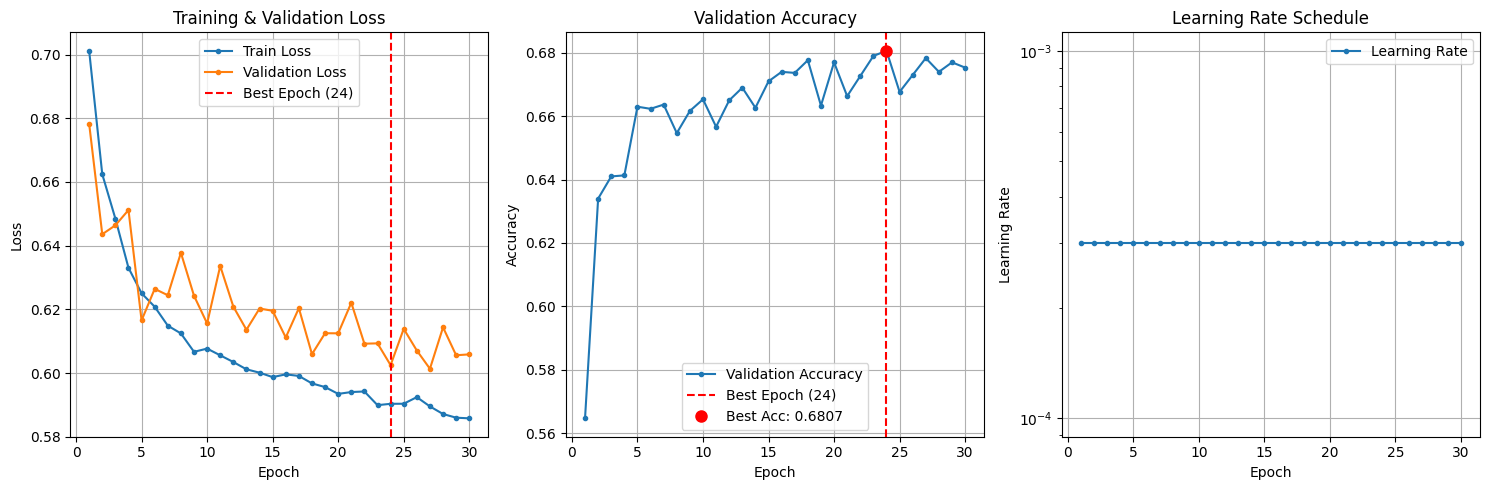


--- Training Complete ---
Best Validation Accuracy achieved: 0.6807


In [13]:

BATCH_SIZE = 64 
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5  
EPOCHS = 30 
SCHEDULER_PATIENCE = 5 
EARLY_STOPPING_PATIENCE = 10


if train_dataset_pyg and val_dataset_pyg:

    train_loader = PyGDataLoader(train_dataset_pyg, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = PyGDataLoader(val_dataset_pyg, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True) 

    print(f"\nCreated DataLoaders:")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

    model = JetGNN(in_dim=NODE_FEATURES_DIM, edge_dim=EDGE_DIM, hidden_dim=128, out_dim=2, heads=4, dropout=0.5).to(device)
    print(f"\nRe-initialized Model on {device}")


    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        scheduler_patience=SCHEDULER_PATIENCE,
        early_stopping_patience=EARLY_STOPPING_PATIENCE
    )


    best_accuracy = trainer.train(epochs=EPOCHS)

    print(f"\n--- Training Complete ---")
    print(f"Best Validation Accuracy achieved: {best_accuracy:.4f}")

else:
    print("Skipping training execution as datasets are not available.")
    best_accuracy = 0.0 


--- Evaluating Best Model on Validation Set ---
Loading best model from best_model_final.pth


<ipython-input-14-3ee90de41758>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load(best_model_path, map_location=device))


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


Best Model Performance on Validation Set:
Validation Loss: 0.6025
Validation Accuracy: 0.6807

Generating Confusion Matrix...


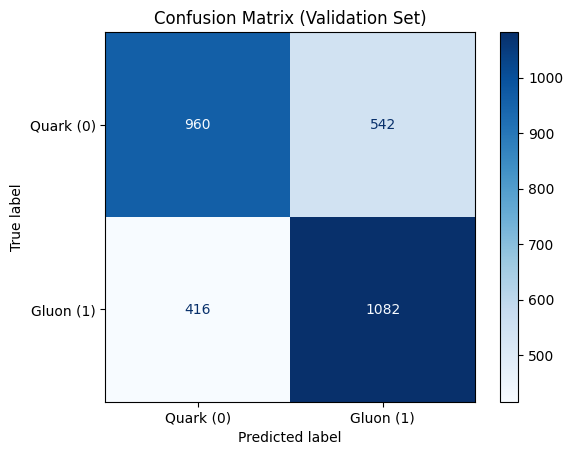


Classification Report (Validation Set):
              precision    recall  f1-score   support

   Quark (0)       0.70      0.64      0.67      1502
   Gluon (1)       0.67      0.72      0.69      1498

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000


Generating UMAP visualization of graph embeddings...


Extracting Embeddings:   0%|          | 0/24 [00:00<?, ?it/s]

Total embeddings extracted: 3000
Fitting UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


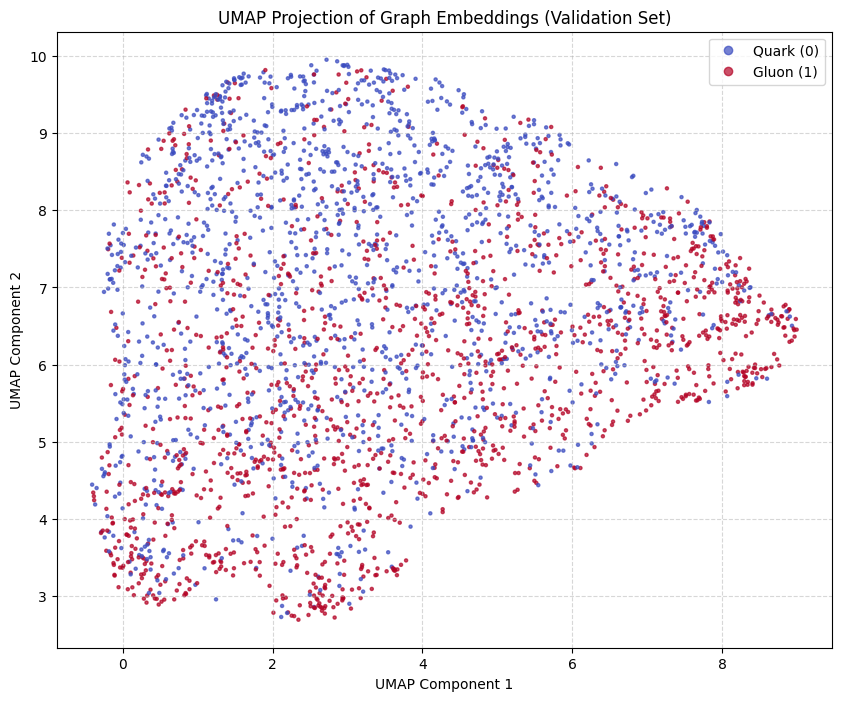

In [14]:

import umap.umap_ as umap

if 'trainer' in locals() and best_accuracy > 0:
    print("\n--- Evaluating Best Model on Validation Set ---")

    best_model_path = "best_model_final.pth"
    if os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path}")
        eval_model = JetGNN(in_dim=NODE_FEATURES_DIM, edge_dim=EDGE_DIM, hidden_dim=128,  out_dim=2, heads=4, dropout=0.5).to(device)
        eval_model.load_state_dict(torch.load(best_model_path, map_location=device))
        eval_model.eval()

        val_loss, val_acc, all_labels, all_preds = trainer.validate() 

        print(f"\nBest Model Performance on Validation Set:")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")

        print("\nGenerating Confusion Matrix...")
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Quark (0)', 'Gluon (1)'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix (Validation Set)")
        plt.show()

        print("\nClassification Report (Validation Set):")
        report = classification_report(all_labels, all_preds, target_names=['Quark (0)', 'Gluon (1)'])
        print(report)

        print("\nGenerating UMAP visualization of graph embeddings...")
        all_embeddings = []
        all_batch_labels = []
        eval_model.eval()
        with torch.no_grad():
             pbar = tqdm(val_loader, desc="Extracting Embeddings", leave=False)
             for data in pbar:
                data = data.to(device)
                _, embeddings = eval_model(data) 
                pooled_embeddings = global_mean_pool(embeddings, data.batch).cpu().numpy()
                all_embeddings.append(pooled_embeddings)
                all_batch_labels.append(data.y.cpu().numpy())

        if all_embeddings:
            all_embeddings = np.concatenate(all_embeddings, axis=0)
            all_batch_labels = np.concatenate(all_batch_labels, axis=0).flatten()
            print(f"Total embeddings extracted: {all_embeddings.shape[0]}")

            reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=SEED)
            print("Fitting UMAP...")
            embedding_2d = reducer.fit_transform(all_embeddings)

            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=all_batch_labels, cmap='coolwarm', s=5, alpha=0.7)
            plt.title('UMAP Projection of Graph Embeddings (Validation Set)')
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.legend(handles=scatter.legend_elements()[0], labels=['Quark (0)', 'Gluon (1)'])
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
        else:
            print("Could not extract embeddings for UMAP.")

    else:
        print(f"Error: Best model file '{best_model_path}' not found. Cannot evaluate.")
else:
    print("\nSkipping final evaluation as training did not complete successfully or was skipped.")